# Entorno

In [ ]:
!pip install tpot --quiet
!pip install imblearn --quiet
!pip install matplotlib

In [41]:
# dataframes
import pandas as pd
import numpy as np

# modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from tpot import TPOTClassifier

# visualización
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

# miscelaneous
import warnings
warnings.filterwarnings('ignore')

In [42]:
def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

In [43]:
tiempo_ejecucion=70

In [44]:
artists_n_genres = pd.read_csv('../artists_n_genres.csv')
artists_n_genres = artists_n_genres[artists_n_genres['popular_genre'].map(artists_n_genres['popular_genre'].value_counts()) > 80]
artists_n_genres.drop(['genres', 'Unnamed: 0'], axis=1, inplace=True)
artists_n_genres.head(3)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,popular_genre
0,"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9,show tunes
2,$NOT,0.544467,0.789800,137910.466667,0.532933,0.023063,0.180300,-9.149267,0.293687,112.344800,0.480700,67.533333,1,1,15,underground hip hop
5,$uicideBoy$,0.141485,0.749344,146386.392000,0.635552,0.045675,0.202253,-6.631304,0.156108,115.022024,0.287286,61.800000,1,1,125,underground hip hop


In [45]:
clases=artists_n_genres['popular_genre'].unique().tolist()
n_clases = len(clases)

In [46]:
generos = pd.DataFrame(clases, columns=['Clase'])
generos

,Clase
0,show tunes
1,underground hip hop
2,new wave pop
3,alternative metal
4,modern rock
5,trap
6,alternative r&b
7,reggae
8,pop rock
9,adult standards


# Experimento 1

- Ejecución tipo `TPOT light`

In [47]:
X = artists_n_genres.drop(['popular_genre', 'artists'], axis=1)
y = artists_n_genres['popular_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

y_train.shape, y_test.shape

((6114,), (2038,))

In [48]:
pipeline_optimizer = TPOTClassifier(
    scoring='roc_auc_ovr',
    max_time_mins=tiempo_ejecucion,
    random_state=42,
    verbosity=2,
    early_stop=5,
    config_dict='TPOT light'
)

pipeline_optimizer.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.8938094730758637

Generation 2 - Current best internal CV score: 0.8938094730758637

Generation 3 - Current best internal CV score: 0.8938094730758637

Generation 4 - Current best internal CV score: 0.8945611778913314

Generation 5 - Current best internal CV score: 0.8972526103187886

Generation 6 - Current best internal CV score: 0.8972526103187886
Optimization Progress:  92%|█████████▏| 736/800 [13:00<00:59,  1.07pipeline/s]

In [ ]:
tpot_preds = pipeline_optimizer.predict(X_test)
#print('accuracy:', accuracy_score(y_test, tpot_preds))
print('roc-auc:', multiclass_roc_auc_score(y_test, tpot_preds))

roc-auc: 0.6555069463804061


In [11]:
from sklearn.linear_model import LogisticRegression

In [13]:
y_test = label_binarize(y_test, classes=clases)
y_scores = classifier.predict_proba(X_test)

In [14]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

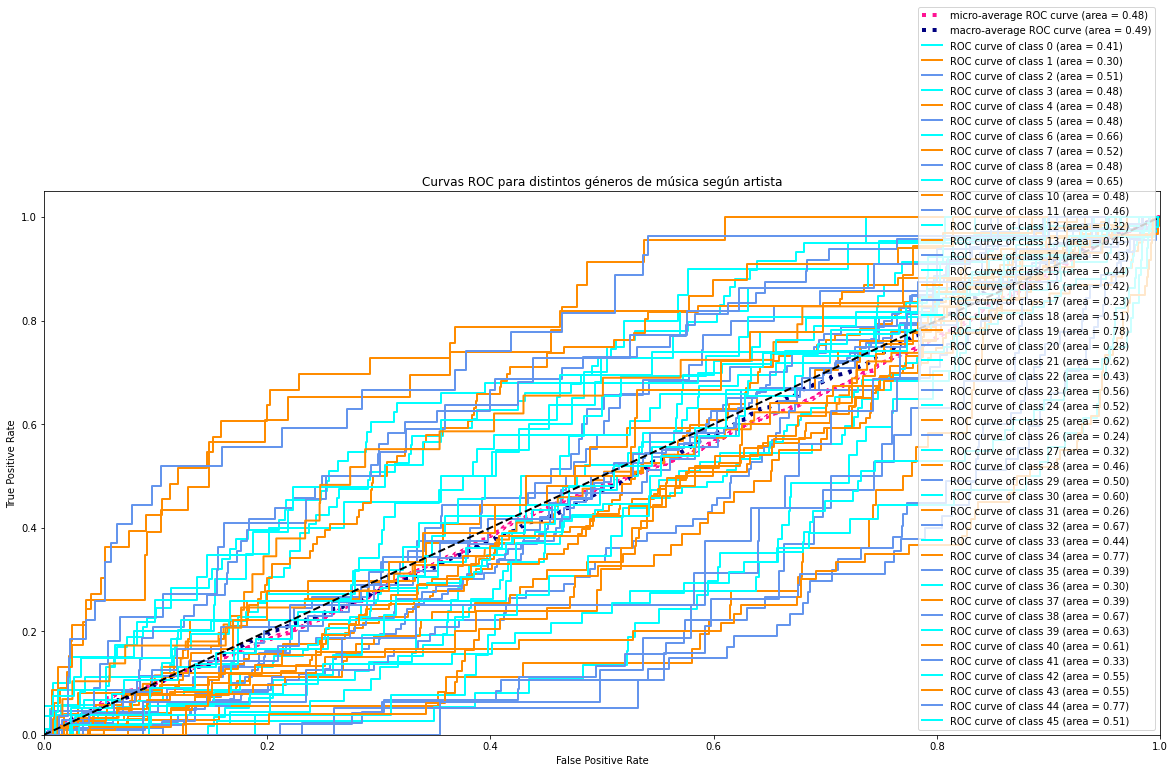

In [15]:
# Plot de todas las clases
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_clases)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_clases):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_clases

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_clases), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para distintos géneros de música según artista')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Ploteo Clase n
ClasePlot = 0

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr[ClasePlot], tpr[ClasePlot], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[ClasePlot])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title((f'Curva ROC de clase {ClasePlot}'))
plt.legend(loc="lower right")
plt.show()

# Experimento 2

- Ejecución tipo `TPOT light` & Balanceo de clases

In [16]:
X = artists_n_genres.drop(['popular_genre', 'artists'], axis=1)
y = artists_n_genres['popular_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

y_train.shape, y_test.shape

((6114,), (2038,))

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [19]:
stratified_split = StratifiedShuffleSplit(
    test_size=.3,
    random_state=333,
    n_splits=2)

X_train, X_test, y_train, y_test = ([] for i in range(4))

X = artists_n_genres.drop(['artists', 'popular_genre'], axis=1)
y = artists_n_genres['popular_genre']

for train_idx, test_idx in stratified_split.split(np.zeros(len(X)), y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [22]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [23]:
pipeline_optimizer = TPOTClassifier(
    scoring='roc_auc_ovr',
    max_time_mins=tiempo_ejecucion,
    random_state=42,
    verbosity=2,
    early_stop=5,
    config_dict='TPOT light'
)

pipeline_optimizer.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.8977571783175609

Generation 2 - Current best internal CV score: 0.8977571783175609

Generation 3 - Current best internal CV score: 0.8977571783175609

Generation 4 - Current best internal CV score: 0.8977571783175609

Generation 5 - Current best internal CV score: 0.9044077364183625

10.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(StandardScaler(input_matrix), C=5.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', early_stop=5, max_time_mins=10,
               random_state=42, scoring='roc_auc_ovr', verbosity=2)

In [24]:
tpot_preds = pipeline_optimizer.predict(X_test)
#print('accuracy:', accuracy_score(y_test, tpot_preds))
print('roc-auc:', multiclass_roc_auc_score(y_test, tpot_preds))

roc-auc: 0.6628835684216913


In [25]:
classifier = LogisticRegression(C=5.0, dual=False, penalty='l2')
classifier.fit(X_train,y_train)

LogisticRegression(C=5.0)

In [26]:
y_test = label_binarize(y_test, classes=clases)
y_scores = classifier.predict_proba(X_test)

In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

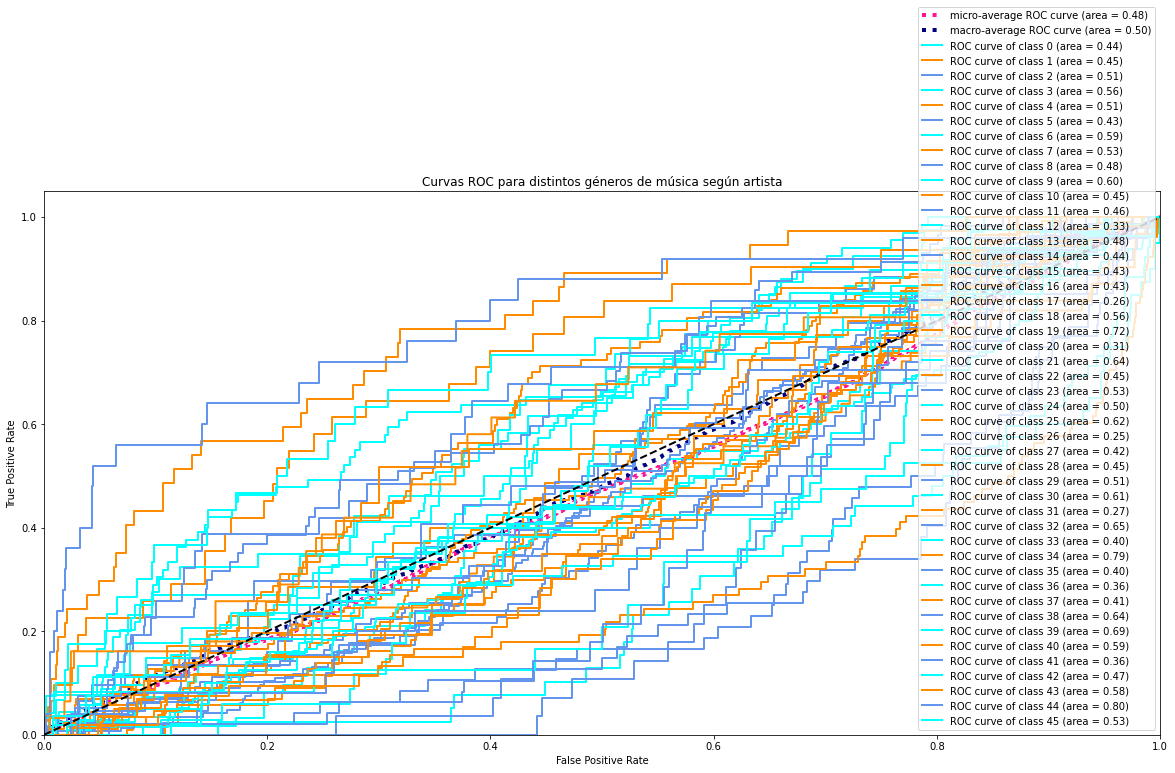

In [28]:
# Plot de todas las clases
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_clases)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_clases):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_clases

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_clases), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para distintos géneros de música según artista')
plt.legend(loc="lower right")
plt.show()

# Experimento 3

De acuerdo a los resultados de los experimentos 1 y 2, el tercer experimento no tendrá la búsqueda tipo `TPOT light` & Balanceo de clases

In [29]:
X = artists_n_genres.drop(['popular_genre', 'artists'], axis=1)
y = artists_n_genres['popular_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

y_train.shape, y_test.shape

((6114,), (2038,))

In [30]:
stratified_split = StratifiedShuffleSplit(
    test_size=.3,
    random_state=333,
    n_splits=2)

X_train, X_test, y_train, y_test = ([] for i in range(4))

X = artists_n_genres.drop(['artists', 'popular_genre'], axis=1)
y = artists_n_genres['popular_genre']

for train_idx, test_idx in stratified_split.split(np.zeros(len(X)), y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [31]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [32]:
pipeline_optimizer = TPOTClassifier(
    scoring='roc_auc_ovr',
    generations=3,
    random_state=42,
    verbosity=2,
)

pipeline_optimizer.fit(X_train, y_train)


21.76 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)


TPOTClassifier(early_stop=5, max_time_mins=20, random_state=42,
               scoring='roc_auc_ovr', verbosity=2)

In [33]:
tpot_preds = pipeline_optimizer.predict(X_test)
#print('accuracy:', accuracy_score(y_test, tpot_preds))
print('roc-auc:', multiclass_roc_auc_score(y_test, tpot_preds))

roc-auc: 0.6865643489430524


In [35]:
from xgboost import XGBClassifier

In [36]:
classifier = XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.45,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [37]:
y_test = label_binarize(y_test, classes=clases)
y_scores = classifier.predict_proba(X_test)

In [38]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

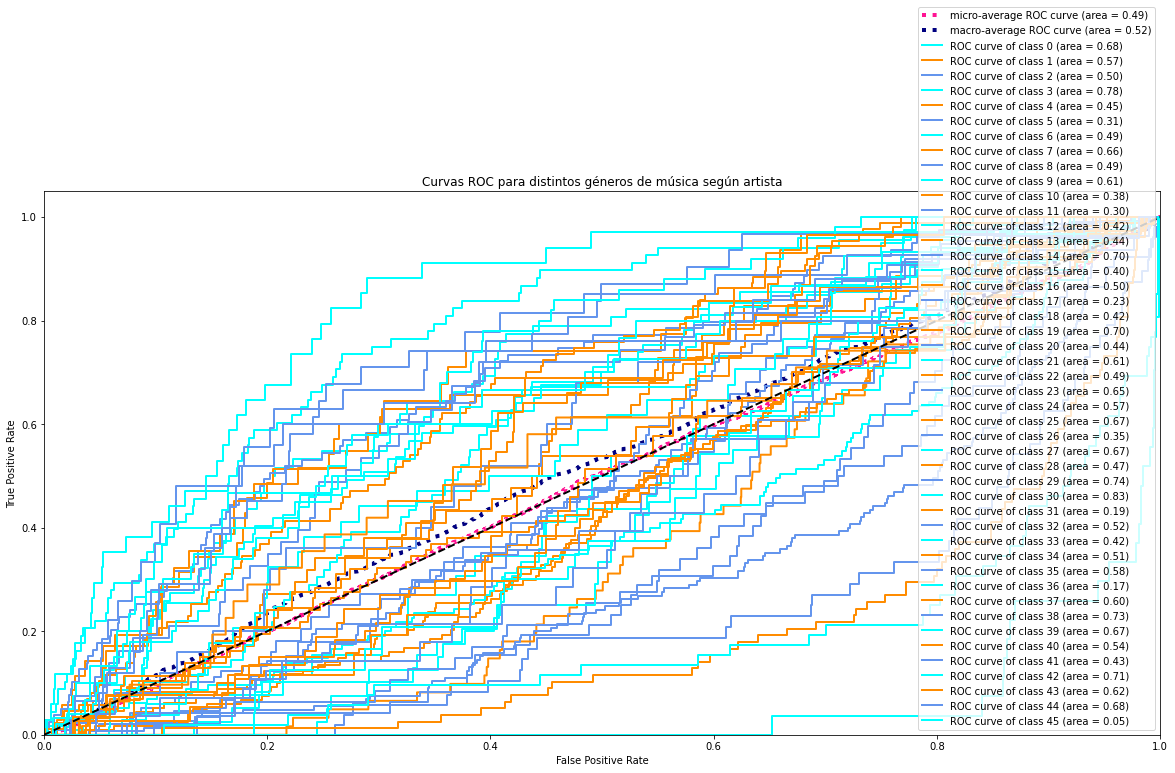

In [39]:
# Plot de todas las clases
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_clases)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_clases):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_clases

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_clases), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para distintos géneros de música según artista')
plt.legend(loc="lower right")
plt.show()